# **Content Similarity Using BoW Feature Vectors**

The main goal of recommender systems is to help users find items they potentially interested in. Depending on the recommendation tasks, an item can be a movie, a restaurant, or, in this case, an online course. 

Machine learning algorithms cannot work on an item directly so we first need to extract features and represent the items mathematically, i.e., with a feature vector.

Many items are often described by text so they are associated with textual data, such as the titles and descriptions of a movie or course. Since machine learning algorithms can not process textual data directly, we need to transform the raw text into numeric feature vectors.


We will extract the bag of words (BoW) features from course titles and descriptions. The BoW feature is a simple but effective feature characterizing textual data and is widely used in many textual machine learning tasks.


## Objectives


* Part 1. Extract Bag of Words (BoW) features from course titles and descriptions and build a course BoW dataset to be used for building a content-based recommender system
* Part 2. Calculate the similarity between any two courses using BoW feature vectors
* Part 3. Obtain the similarity between courses from a course similarity matrix
* Part 4. Use the course similarity matrix to find and recommend new courses which are similar to enrolled courses


----


In [1]:
import gensim
import pandas as pd
import numpy as np 
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora

from scipy.spatial.distance import cosine

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Download stopwords


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/brncat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brncat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/brncat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# also set a random state
rs = 123

----

# Part 1. Extract Bag of Words (BoW) Features from Course Textual Content and Build a Dataset

Let's start extracting BoW features from some real course textual content.


In [4]:
course_content_df = pd.read_csv("course_processed.csv")
course_content_df.shape

(307, 3)

In [5]:
course_content_df.head()

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...


The course content dataset has three columns `COURSE_ID`, `TITLE`, and `DESCRIPTION`. `TITLE` and `DESCRIPTION` are all text upon which we want to extract BoW features. 


Let's join those two text columns together.


In [6]:
# Merge TITLE and DESCRIPTION title
course_content_df_2 = course_content_df.copy()
course_content_df_2['course_texts'] = course_content_df_2[['TITLE', 'DESCRIPTION']].agg(' '.join, axis=1)
course_content_df_2 = course_content_df_2.reset_index()
course_content_df_2['index'] = course_content_df_2.index

In [7]:
course_content_df_2.head() 

,index,COURSE_ID,TITLE,DESCRIPTION,course_texts
0,0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...,robots are coming build iot apps with watson ...
1,1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...,accelerating deep learning with gpu training c...
2,2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...,consuming restful services using the reactive ...
3,3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...,analyzing big data in r using apache spark apa...
4,4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...,containerizing packaging and running a sprin...


In [8]:
course_content_df_2.iloc[0, :]

index                                                           0
COURSE_ID                                                ML0201EN
TITLE           robots are coming  build iot apps with watson ...
DESCRIPTION     have fun with iot and learn along the way  if ...
course_texts    robots are coming  build iot apps with watson ...
Name: 0, dtype: object

We have used the `tokenize_course()` method  to tokenize the course content:


In [9]:
def tokenize_course(course, keep_only_nouns=True):
    # Get English stop words
    stop_words = set(stopwords.words('english'))
    # Tokenize the course text
    word_tokens = word_tokenize(course)
    # Remove English stop words and numbers
    word_tokens = [w for w in word_tokens if (not w.lower() in stop_words) and (not w.isnumeric())]
    # Only keep nouns 
    if keep_only_nouns:
        # Define a filter list of non-noun POS tags
        filter_list = ['WDT', 'WP', 'WRB', 'FW', 'IN', 'JJR', 'JJS', 'MD', 'PDT', 'POS', 'PRP', 'RB', 'RBR', 'RBS',
                       'RP']
        # Tag the word tokens with POS tags
        tags = nltk.pos_tag(word_tokens)
        # Filter out non-nouns based on POS tags
        word_tokens = [word for word, pos in tags if pos not in filter_list]

    return word_tokens

Let's try it on the first course.


In [10]:
a_course = course_content_df_2.iloc[0, :]['course_texts']
a_course

'robots are coming  build iot apps with watson  swift  and node red have fun with iot and learn along the way  if you re a swift developer and want to learn more about iot and watson ai services in the cloud  raspberry pi   and node red  you ve found the right place  you ll build iot apps to read temperature data  take pictures with a raspcam  use ai to recognize the objects in those pictures  and program an irobot create 2 robot  '

In [11]:
tokenize_course(a_course)

['robots',
 'coming',
 'build',
 'iot',
 'apps',
 'watson',
 'swift',
 'red',
 'fun',
 'iot',
 'learn',
 'way',
 'swift',
 'developer',
 'want',
 'learn',
 'iot',
 'watson',
 'ai',
 'services',
 'cloud',
 'raspberry',
 'pi',
 'node',
 'red',
 'found',
 'place',
 'build',
 'iot',
 'apps',
 'read',
 'temperature',
 'data',
 'take',
 'pictures',
 'raspcam',
 'use',
 'ai',
 'recognize',
 'objects',
 'pictures',
 'program',
 'irobot',
 'create',
 'robot']

Next, we start by tokenzing all courses in the `courses_df`:


In [12]:
tokenized_courses_df = course_content_df_2['course_texts'].apply(tokenize_course) 

In [13]:
tokenized_courses_df

0      [robots, coming, build, iot, apps, watson, swi...
1      [accelerating, deep, learning, gpu, training, ...
2      [consuming, restful, services, using, reactive...
3      [analyzing, big, data, r, using, apache, spark...
4      [containerizing, packaging, running, spring, b...
                             ...                        
302    [javascript, jquery, json, course, look, javas...
303    [programming, foundations, javascript, html, c...
304    [front, end, web, development, react, course, ...
305    [introduction, web, development, course, desig...
306    [interactivity, javascript, jquery, course, th...
Name: course_texts, Length: 307, dtype: object

Then we need to create a token dictionary `tokens_dict`


In [14]:
tokens_dict = gensim.corpora.Dictionary(tokenized_courses_df)

Then we can use `doc2bow()` method to generate BoW features for each tokenized course.


In [15]:
courses_bow = [tokens_dict.doc2bow(course) for course in tokenized_courses_df]

Lastly, we need to append the BoW features for each course into a new BoW dataframe. The new dataframe needs to include the following columns:
- 'doc_index': the course index starting from 0
- 'doc_id': the actual course id such as `ML0201EN`
- 'token': the tokens for each course
- 'bow': the bow value for each token

In [16]:
bow_values = [] 
tokens = [] 
doc_ids = []
doc_indices = []
for doc_index, doc_bow in enumerate(courses_bow):
    for token_index, token_bow in doc_bow:
        doc_indices.append(doc_index)
        tokens.append(tokens_dict[token_index]) 
        doc_ids.append(course_content_df['COURSE_ID'].loc[doc_index]) 
        bow_values.append(token_bow)

bow_dicts = {"doc_index": doc_indices,
          "doc_id": doc_ids,
          "token": tokens,
          "bow": bow_values}

# bow_df_index and bows_df are different by the absence of the column 'doc_index' in bows_df
bows_df = pd.DataFrame(bow_dicts)

bows_df.head()

,doc_index,doc_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1


----

# Part 2. Calculate Course Similarity using BoW Features

 We have just extracted the BoW features from course textual content by creating the bows_df DataFrame. Given the course BoW feature vectors, we can easily apply similarity measurement to calculate the course similarity using many similarity measurements such as `consine`, `jaccard index`, or `euclidean distance` as shown in the below figure. Here we stick with `consine` similarity measurement, but others could be applied as easily.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_2/images/course_sim.png)

In [17]:
course_content_df.head()

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...


Given course ID `ML0101ENv3`, let's find out its title and description:

In [18]:
course_content_df[course_content_df['COURSE_ID'] == 'ML0101ENv3']

,COURSE_ID,TITLE,DESCRIPTION
158,ML0101ENv3,machine learning with python,machine learning can be an incredibly benefici...


We can see it is a machine learning with Python course so we can expect any machine learning or Python related courses would be similar.


In [19]:
ml_course = bows_df[bows_df['doc_id'] == 'ML0101ENv3']
ml_course

,doc_index,doc_id,token,bow
2747,158,ML0101ENv3,course,1
2748,158,ML0101ENv3,learning,4
2749,158,ML0101ENv3,machine,3
2750,158,ML0101ENv3,need,1
2751,158,ML0101ENv3,get,1
2752,158,ML0101ENv3,started,1
2753,158,ML0101ENv3,python,2
2754,158,ML0101ENv3,tool,1
2755,158,ML0101ENv3,tools,1
2756,158,ML0101ENv3,predict,1


We can see the BoW feature vector is in vertical format but normally feature vectors are in horizontal format.

In [20]:
ml_courseT = ml_course.pivot(index=['doc_id'], columns='token').reset_index(level=[0])
ml_courseT

doc_id  doc_index                                               \
token             beneficial course free future  get give hidden insights   
0      ML0101ENv3        158    158  158    158  158  158    158      158   

                ...     bow                                                    \
token learning  ... machine need predict python started supervised tool tools   
0          158  ...       3    1       1      2       1          1    1     1   

                           
token trends unsupervised  
0          1            1  

[1 rows x 39 columns]

To compare the BoWs of any two courses, which normally have a different set of tokens, we need to create a union token set and then transpose them. We have provided a method called `pivot_two_bows` as follows:

In [21]:
def pivot_two_bows(basedoc, comparedoc):
    """
    Pivot two bag-of-words (BoW) representations for comparison.

    Parameters:
    basedoc (DataFrame): DataFrame containing the bag-of-words representation for the base document.
    comparedoc (DataFrame): DataFrame containing the bag-of-words representation for the document to compare.

    Returns:
    DataFrame: A DataFrame with pivoted BoW representations for the base and compared documents,
    facilitating direct comparison of word occurrences between the two documents.
    """

    # Create copies of the input DataFrames to avoid modifying the originals
    base = basedoc.drop('doc_index',axis=1).copy()
    base['type'] = 'base'  # Add a 'type' column indicating base document
    compare = comparedoc.drop('doc_index',axis=1).copy()
    compare['type'] = 'compare'  # Add a 'type' column indicating compared document

    # Concatenate the two DataFrames vertically
    join = pd.concat([base, compare])

    # Pivot the concatenated DataFrame based on 'doc_id' and 'type', with words as columns
    joinT = join.pivot(index=['doc_id', 'type'], columns='token').fillna(0).reset_index(level=[0, 1])

    # Assign meaningful column names to the pivoted DataFrame
    joinT.columns = ['doc_id', 'type'] + [t[1] for t in joinT.columns][2:]

    # Return the pivoted DataFrame for comparison
    return joinT

In [22]:
course1 = bows_df[bows_df['doc_id'] == 'ML0151EN']
course2 = bows_df[bows_df['doc_id'] == 'ML0101ENv3']

In [23]:
bow_vectors = pivot_two_bows(course1, course2)
bow_vectors

,doc_id,type,approachable,basics,beneficial,comparison,course,dives,free,future,...,relates,started,statistical,supervised,tool,tools,trends,unsupervised,using,vs
0,ML0101ENv3,compare,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,ML0151EN,base,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


Similarly, we can use the cosine method to calculate their similarity:

In [24]:
similarity = 1 - cosine(bow_vectors.iloc[0, 2:], bow_vectors.iloc[1, 2:])
similarity

0.6626221399549089

Now our task is to finding all courses similar to the course `Machine Learning with Python`:


In [25]:
course_content_df[course_content_df['COURSE_ID'] == 'ML0101ENv3']

,COURSE_ID,TITLE,DESCRIPTION
158,ML0101ENv3,machine learning with python,machine learning can be an incredibly benefici...


In [26]:
bows_df.columns

Index(['doc_index', 'doc_id', 'token', 'bow'], dtype='object')

In [27]:
def suggest_course(course_id, course_df, bows_df):
    """
    suggest a list of couser based on cosine similarity with a ginven COURSE_ID.

    Parameters:
    course_id (str): the COURSE_ID which we want to find similar course list.
    course_df (DataFrame): DataFrame representation of course content. It has three columns `COURSE_ID`, `TITLE`, and `DESCRIPTION`.
    bows_df (DataFrame): DataFrame containing the bag-of-words representation for the document to compare.

    Returns:
    DataFrame: A DataFrame with pivoted BoW representations for the base and compared documents,
    facilitating direct comparison of word occurrences between the two documents.
    """
    # we can set a similarity threshold such as 0.5 to determine if two courses are similar enough.
    trh = 0.5

    course_df = course_df[['COURSE_ID','TITLE']].copy()

    num = course_df['COURSE_ID'][course_df['COURSE_ID'] != course_id]

    course2 = bows_df[bows_df['doc_id'] == course_id]

    titles = []
    for i in num:
        course1 = bows_df[bows_df['doc_id'] == i]
        bow_vectors = pivot_two_bows(course1, course2)
        similarity = 1 - cosine(bow_vectors.iloc[0, 2:], bow_vectors.iloc[1, 2:])
        if similarity >= trh:
            titles.append(i)

    df = course_df[course_df['COURSE_ID'].isin(titles)]  
    return df

In [28]:
suggest_course('ML0101ENv3', course_content_df, bows_df)

,COURSE_ID,TITLE
157,ML0109EN,machine learning dimensionality reduction
200,ML0151EN,machine learning with r
259,excourse46,machine learning
260,excourse47,machine learning for all
273,excourse60,introduction to tensorflow for artificial inte...


We have just successfully found a list of courses similar to the course `ML0101ENv3`: `Machine Learning with Python` based on cosine similarity of the features extracted with BoW from course titles and description.

----

# **Part 3. Obtain the similarity between courses from a course similarity matrix**

We can now use the function `pivot_two_bows` to compute the similarity matrix by iterating through all possible course pairs and calculating their similarities.

The similarity matrix is a real number, symmetric metric with each element representing the similarity value (ranged 0 to 1) between course index `i` and course index `j`. 

In [29]:
all_courses = bows_df['doc_id'].unique()
n_courses = len(all_courses)

# We create a matrix with zeros where we are going to replace the lower diagonal matrix elements with the similarity measures.
sim_matrix = np.zeros((n_courses,n_courses))

# iterate through all possible course pairs and calculate their similarities.
for i,coursei in enumerate(all_courses):
    course1_df = bows_df[bows_df['doc_id'] == coursei]
    for j,coursej in enumerate(all_courses):
        course2_df = bows_df[bows_df['doc_id'] == coursej]
        # Compute only lower triangular matrix elements as the matrix is symmetric
        if j<=i: 
            bow_vectors = pivot_two_bows(course1_df, course2_df)
            similarity = 1 - cosine(bow_vectors.iloc[0, 2:], bow_vectors.iloc[1, 2:])
            sim_matrix[i][j] = similarity

sim_df = pd.DataFrame(sim_matrix) 

In [30]:
sim_df

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.088889,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.088475,0.055202,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.065556,0.057264,0.026463,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.048810,0.012182,0.039406,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.033944,0.028239,0.018270,0.094759,0.060474,0.064851,0.053856,0.039467,0.036539,0.060474,...,0.047186,0.116008,0.137406,0.211743,0.256220,1.000000,0.000000,0.000000,0.000000,0.0
303,0.076825,0.063911,0.082698,0.030638,0.030415,0.000000,0.000000,0.119098,0.055132,0.045622,...,0.177989,0.092381,0.145126,0.527636,0.249675,0.211520,1.000000,0.000000,0.000000,0.0
304,0.073278,0.138990,0.134095,0.017534,0.130548,0.009333,0.000000,0.255599,0.094656,0.026110,...,0.153927,0.105739,0.139415,0.282573,0.133670,0.169473,0.243531,1.000000,0.000000,0.0
305,0.039276,0.031367,0.012684,0.018796,0.000000,0.015008,0.024926,0.082199,0.076102,0.055978,...,0.149234,0.093962,0.162170,0.476644,0.222350,0.129766,0.416067,0.221307,1.000000,0.0


We could use `seaborn` to visualize the similarity metric, and since it is symmetric, we can just show the triangular  matrix (lower left):

<Axes: >

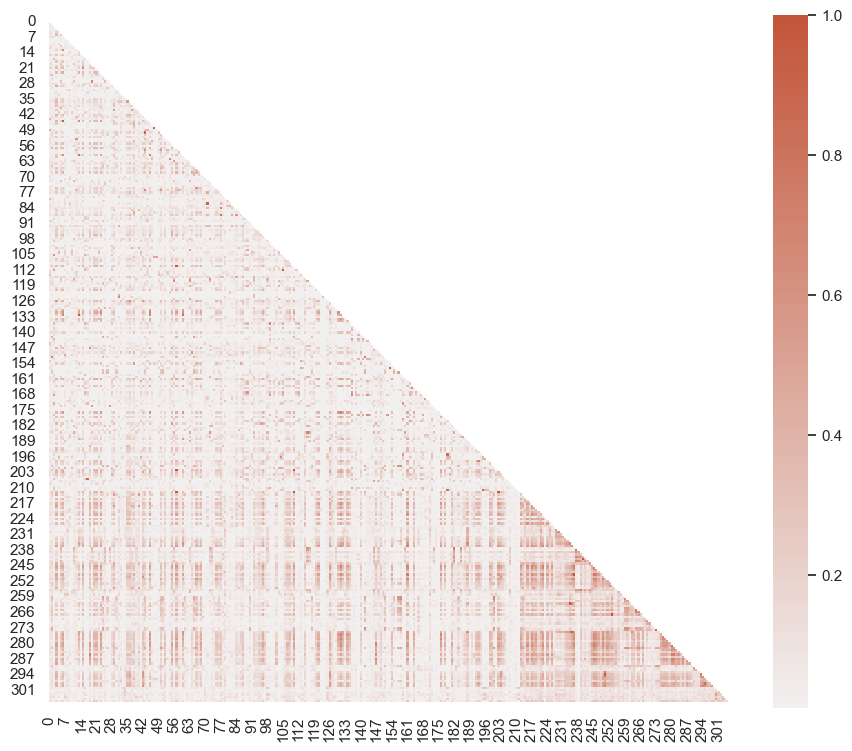

In [31]:
# Configure seaborn to set the plot style to 'white'
sns.set_theme(style="white")

# Create a mask for the upper triangle of the similarity matrix
mask = np.triu(np.ones_like(sim_df, dtype=bool))

# Create a new figure and axis for the heatmap
_, ax = plt.subplots(figsize=(11, 9))

# Create a diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot a similarity heat map using seaborn's heatmap function
sns.heatmap(sim_df, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)

Next, we are going to need the `bows_df_index` DataFrame in order to relate the column `doc_index` with `doc_id`. Let's take a look at it again:

In [32]:
bows_df.head()

,doc_index,doc_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1


First, we notice that the `doc_index` are course indices (such as `0, 1, 2, 3`). Very often we need to query the actual course ids (such as `ML0151EN` and `ML0101ENv3`) based on course indices and vice versa. We can save the course id's and indices into two dictionaries for late queries:

Then, based on the `doc_index` and `doc_id` columns, we create an index to id mapping and another id to index mapping in two Python dictionaries:

In [33]:
# Create course id to index and index to id mappings
def get_doc_dicts(bow_df):
    # Group the DataFrame by course index and ID, and get the maximum value for each group
    grouped_df = bow_df.groupby(['doc_index', 'doc_id']).max().reset_index(drop=False)
    # Create a dictionary mapping indices to course IDs
    idx_id_dict = grouped_df[['doc_id']].to_dict()['doc_id']
    # Create a dictionary mapping course IDs to indices
    id_idx_dict = {v: k for k, v in idx_id_dict.items()}
    # Clean up temporary DataFrame
    del grouped_df
    return idx_id_dict, id_idx_dict

For example, suppose we want to know the indexes of the items "ML0151EN" and "ML0101ENv3".

In [34]:
idx_id_dict, id_idx_dict = get_doc_dicts(bows_df)
idx1 = id_idx_dict["ML0151EN"]
idx2 = id_idx_dict["ML0101ENv3"]
print(f"Course 1's index is {idx1} and Course 2's index is {idx2}")

Course 1's index is 200 and Course 2's index is 158


Then we can locate their similarity value in row 200 and col 158, `sim_matrix[200][158]`:

In [35]:
sim = sim_matrix[idx1][idx2]
sim

0.6626221399549089

### Example: Find courses which are similar enough to your enrolled courses.

As an example we can check the recommendations for a selected list of courses given below:

In [36]:
enrolled_course_ids = ['ML0151EN'] # add your interested coures id to the list

In [37]:
enrolled_courses = course_content_df[course_content_df['COURSE_ID'].isin(enrolled_course_ids)]
enrolled_courses

,COURSE_ID,TITLE,DESCRIPTION
200,ML0151EN,machine learning with r,this machine learning with r course dives into...


In [38]:
all_courses = set(course_content_df['COURSE_ID'])

unselected_course_ids = all_courses.difference(enrolled_course_ids)


Now, we iterate each unselect course and check if it is similar enough to any of your selected courses. If the similarity is larger than a threshold such as 0.5, then add it to the course recommendation list:

In [39]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix):
    # Create a dictionary to store your recommendation results
    res = {}
    # Set a threshold for similarity
    threshold = 0.5 
    # Iterate over enrolled courses
    for enrolled_course in enrolled_course_ids:
        # Iterate over unselected courses
        for unselect_course in unselected_course_ids:
            # Check if both enrolled and unselected courses exist in the id_idx_dict
            if enrolled_course in id_idx_dict and unselect_course in id_idx_dict:
                # Initialize similarity value
                simm = 0
                
                idx1 = id_idx_dict[enrolled_course]
                idx2 = id_idx_dict[unselect_course]
                
                # Find the similarity value from the sim_matrix
                simm = sim_matrix[idx1][idx2]
                 # Check if the similarity exceeds the threshold
                if simm > threshold:
                    # Update recommendation dictionary with course ID and similarity score
                    if unselect_course not in res:
                        # If the unselected course is not already in the recommendation dictionary (`res`), add it.
                        res[unselect_course] = simm
                    else:
                        # If the unselected course is already in the recommendation dictionary (`res`), compare the similarity score.
                        # If the current similarity score is greater than or equal to the existing similarity score for the course,
                        # update the similarity score in the recommendation dictionary (`res`) with the current similarity score.
                        if simm >= res[unselect_course]:
                            res[unselect_course] = simm
                            
    # Sort the results by similarity
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
     # Return the recommendation dictionary
    return res

In [40]:
rev = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
rev 

{'ML0101ENv3': 0.6626221399549089, 'ML0109EN': 0.5715005715008572}

Based on the selectec course `ML0151EN`, it recommended the courses `ML0101ENv3` and `ML0109EN` based on their similarity score.

----

# **Part 4. Content-based Course Recommender System using Course Similarity Matrix For All Test Users**

Next, let's sample a test dataset, containing 1000 test users to whom we want to make course recommendations.

In [41]:
# load the ratings_df to extract the users
ratings_df = pd.read_csv('ratings.csv')

np.random.seed(rs)
test_usesrs = np.random.choice(ratings_df['user'].unique(), size=1000, replace=False) # take 1000 random users from ratings_df['user']

test_users_df = ratings_df[ratings_df['user'].isin(test_usesrs)]
test_users_df

,user,item,rating
15,1474302,DS0103EN,4
51,687207,ST0101EN,4
137,1897257,CNSC02EN,4
155,1805227,DV0101EN,5
188,759038,BD0111EN,5
...,...,...,...
233238,1192416,BD0111EN,5
233258,1801743,ML0115EN,3
233267,1894663,DS0101EN,4
233298,2049069,DS0105EN,3


We can finaly use the `generate_recommendations_for_all()` method to generate recommendations for all users.

In [42]:
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    enrolled = []
    rec_num = [] # num of recommendations
    
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    
    for user_id in test_user_ids:
        enrolled_course_ids = test_users[test_users['user'] == user_id]['item']
        unselected_course_ids = all_courses.difference(enrolled_course_ids)
        users.append(user_id)
        enrolled.append(list(enrolled_course_ids))
        rev = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
        courses.append( list(rev.keys()) )
        sim_scores.append( list(rev.values()) )
        rec_num.append( len(list(rev.values())) )
        pass
    
    return users, enrolled, courses, sim_scores, rec_num

In [43]:
pd.set_option('max_colwidth', None)

In [44]:
res_dict = {}
users, enrolled, courses, sim_scores, rec_num = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['ENROLLED'] = enrolled
res_dict['RECOMMENDATIONS'] = courses
res_dict['COUNT'] = rec_num
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'ENROLLED', 'RECOMMENDATIONS', 'COUNT', 'SCORE']).sort_values(by='COUNT',ascending=False)
res_df.head(10)

,USER,ENROLLED,RECOMMENDATIONS,COUNT,SCORE
677,1281097,[DS0110EN],"[TMP0106, DS0201EN, TMP107, DS0107, DX0106EN, ML0122ENv1, ML0120EN]",7,"[0.6666666666666667, 0.6454972243679028, 0.6123724356957946, 0.6123724356957946, 0.6064784348631227, 0.5252257314388903, 0.5222329678670935]"
451,971918,[DS0110EN],"[TMP0106, DS0201EN, TMP107, DS0107, DX0106EN, ML0122ENv1, ML0120EN]",7,"[0.6666666666666667, 0.6454972243679028, 0.6123724356957946, 0.6123724356957946, 0.6064784348631227, 0.5252257314388903, 0.5222329678670935]"
548,1074551,[DS0110EN],"[TMP0106, DS0201EN, TMP107, DS0107, DX0106EN, ML0122ENv1, ML0120EN]",7,"[0.6666666666666667, 0.6454972243679028, 0.6123724356957946, 0.6123724356957946, 0.6064784348631227, 0.5252257314388903, 0.5222329678670935]"
414,927448,[DS0101EN],"[DS0110EN, TMP0106, DS0201EN, TMP107, DS0107, DX0106EN]",6,"[0.7329409123199365, 0.5979254811031062, 0.567733589433837, 0.5669467095138409, 0.5669467095138409, 0.5439433649162873]"
138,509574,[DS0101EN],"[DS0110EN, TMP0106, DS0201EN, TMP107, DS0107, DX0106EN]",6,"[0.7329409123199365, 0.5979254811031062, 0.567733589433837, 0.5669467095138409, 0.5669467095138409, 0.5439433649162873]"
137,508361,[DS0101EN],"[DS0110EN, TMP0106, DS0201EN, TMP107, DS0107, DX0106EN]",6,"[0.7329409123199365, 0.5979254811031062, 0.567733589433837, 0.5669467095138409, 0.5669467095138409, 0.5439433649162873]"
136,506207,[DS0101EN],"[DS0110EN, TMP0106, DS0201EN, TMP107, DS0107, DX0106EN]",6,"[0.7329409123199365, 0.5979254811031062, 0.567733589433837, 0.5669467095138409, 0.5669467095138409, 0.5439433649162873]"
123,466781,[DS0101EN],"[DS0110EN, TMP0106, DS0201EN, TMP107, DS0107, DX0106EN]",6,"[0.7329409123199365, 0.5979254811031062, 0.567733589433837, 0.5669467095138409, 0.5669467095138409, 0.5439433649162873]"
810,1546898,[DS0101EN],"[DS0110EN, TMP0106, DS0201EN, TMP107, DS0107, DX0106EN]",6,"[0.7329409123199365, 0.5979254811031062, 0.567733589433837, 0.5669467095138409, 0.5669467095138409, 0.5439433649162873]"
821,1566718,[DS0101EN],"[DS0110EN, TMP0106, DS0201EN, TMP107, DS0107, DX0106EN]",6,"[0.7329409123199365, 0.5979254811031062, 0.567733589433837, 0.5669467095138409, 0.5669467095138409, 0.5439433649162873]"


With the recommendations generated for each user, you need to write some extra analytic code to answer the following questions:

- On average, how many new/unseen courses have been recommended to each user?
- What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users?

In [45]:
res_df.describe()

,USER,COUNT
count,1.000000e+03,1000.000000
mean,1.049213e+06,1.029000
std,4.964586e+05,1.453365
min,9.000000e+00,0.000000
25%,6.699710e+05,0.000000
50%,1.023115e+06,1.000000
75%,1.438584e+06,1.000000
max,2.102680e+06,7.000000


Based on a similarity threshold of 0.5, on average one course per user has been recommended.

In [46]:
# To collect the most recommended courses, we collect them in a list and count the 10 most recoommended courses

courses_1 = res_df['RECOMMENDATIONS'].values

courses_flat = []
for x in courses_1:
    for y in x:
        courses_flat.append(y)

df_2 = pd.DataFrame(pd.Series(courses_flat).value_counts()[:10], columns=['Count'])
df_2 = df_2.reset_index().rename_axis(index=None, columns=None).rename(columns={"index": "COURSE_ID"})
df_2 

,COURSE_ID,Count
0,TMP107,245
1,DS0110EN,143
2,DA0151EN,65
3,DX0106EN,61
4,DS0201EN,61
5,TMP0106,58
6,DS0107,58
7,WA0103EN,58
8,CB0101EN,36
9,TMP0101EN,29


To find the names of those courses, we need the `course_content_df` dataset to extract the names from the `COURSE_ID`.

In [47]:
mask = course_content_df['COURSE_ID'].isin(pd.Series(courses_flat).value_counts()[:10].axes[0].values)
df_3 = course_content_df[mask][['COURSE_ID','TITLE']].reset_index(drop=True)

pd.merge(df_2,df_3, left_on='COURSE_ID', right_on='COURSE_ID')

,COURSE_ID,Count,TITLE
0,TMP107,245,data science bootcamp with python
1,DS0110EN,143,data science with open data
2,DA0151EN,65,data analysis using r 101
3,DX0106EN,61,data science bootcamp with r for university proffesors
4,DS0201EN,61,end to end data science on cloudpak for data
5,TMP0106,58,data science bootcamp
6,DS0107,58,data science career talks
7,WA0103EN,58,watson analytics for social media
8,CB0101EN,36,build your own chatbots
9,TMP0101EN,29,text analysis


And that is the list of the 10-most recommended courses.

----

In the next notebook we are going to: (a) feature engineer a user profile based on course genres and rating, and (b) generate course recommendations based on a user's profile and course genres.